# Setup

In [1]:
from langchain_core.language_models import BaseChatModel
from langchain_openai import ChatOpenAI
from langchain_anthropic import ChatAnthropic

# dummy tool
def get_weather(location: str): 
    """Get the weather for a given location"""
    return f"The weather in {location} is 70 degrees"

In [ ]:
def print_stream(stream):
    """A utility to pretty print the stream."""
    for s in stream:
        message = s
        if isinstance(message, tuple):
            print(message)
        else:
            message.pretty_print()

In [2]:
openai_model_w_tool = ChatOpenAI(model="gpt-4o").bind_tools([get_weather])
anthropic_model_w_tool = ChatAnthropic(model="claude-3-5-sonnet-20240620").bind_tools([get_weather])

# Alternative reproduction of error:


V well handled:
- using prebuilt tool node and prebuilt react agent (which uses toolnode) / BaseTool already works perfectly because error returned neatly as ToolMessage
  - default arg will [neatly return ToolMessage](https://github.com/langchain-ai/langgraph/blob/c0b56bf60d84ed435609c35b0691cd0305ceae78/libs/langgraph/langgraph/prebuilt/tool_node.py#L181-L185)

- separated tool calls/tool message (e.g. when choosing messages to summarise - helper with trim_messages helper, but need to be aware as it's not default)
- tool/function that is invoked outside of ToolNode that doesn't have its own error handling (specifically ToolMessage returned)
  - Various gotchas when switching models to anthropic from openai - below show 1 example workflow 

### Example workflow that could result in confusion: switching out models causing non-tool function to interrupt execution
First, use OpenAI model only

In [4]:
from langgraph.graph import StateGraph, MessagesState, END,START
from langgraph.prebuilt import ToolNode
from langgraph.checkpoint.memory import MemorySaver
import functools

tools = [get_weather]
tool_node = ToolNode(tools)
# Define the graph
memory = MemorySaver()

def should_continue(state: MessagesState):
    messages = state["messages"]
    last_message = messages[-1]
    if last_message.tool_calls:
        return "tools"
    return END

def call_model(state: MessagesState, model: BaseChatModel):
    messages = state["messages"]
    response = model.invoke(messages)
    return {"messages": [response]}


# calling simple .upper() method but could be a text-to-speech service for e.g.
def function_assuming_string(state:MessagesState):
    last_message = state["messages"][-1]
    print(f"Calling string method: {last_message.content.upper()}")
    return

def function_typechecking_string(state:MessagesState):
    last_message = state["messages"][-1]
    if isinstance(last_message.content, str):
      print(f"Calling string method: {last_message.content.upper()}")
    else:
      print(f"Calling string method: {last_message.content[0]['text'].upper()}")

In [5]:
openai_model = functools.partial(call_model,model=openai_model_w_tool)

workflow = StateGraph(MessagesState)
workflow.add_node("agent", openai_model)  # Using OpenAI model by default
workflow.add_node("tools", tool_node)

workflow.add_edge(START, "agent")
workflow.add_conditional_edges("agent", should_continue, ["tools", END])
workflow.add_edge("tools", "agent")

workflow.add_node("tts", function_assuming_string) # This will work on oai, even when there's a tool call
workflow.add_edge("agent", "tts")
workflow.add_edge("tts",END)

graph = workflow.compile(checkpointer=memory)

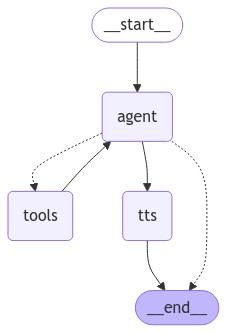

In [6]:
from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

In [7]:
# imagine back/forth with user, then tool call
config = {"configurable": {"thread_id": "2"}}
for chunk in graph.stream({'messages': ['what is weather in sf']}, config=config, stream_mode='values'):
  chunk['messages'][-1].pretty_print()

================================ Human Message =================================

what is weather in sf
================================== Ai Message ==================================
Tool Calls:
  get_weather (call_WA6BBbAPmqtAQBGXjXzBVoqn)
 Call ID: call_WA6BBbAPmqtAQBGXjXzBVoqn
  Args:
    location: San Francisco, CA
Calling string method: 
================================= Tool Message =================================
Name: get_weather

The weather in San Francisco, CA is 70 degrees
================================== Ai Message ==================================

The current weather in San Francisco, CA is 70 degrees Fahrenheit.
Calling string method: THE CURRENT WEATHER IN SAN FRANCISCO, CA IS 70 DEGREES FAHRENHEIT.


### Now, changing nothing else except to use ChatAnthropic, you'd get an error because of different response.content format
(in practice you'd probably just change the variable name and rerun the cell.)

In [8]:
anthropic_model = functools.partial(call_model,model=anthropic_model_w_tool)

workflow = StateGraph(MessagesState)
workflow.add_node("agent", anthropic_model)  # changed to Anthropic
workflow.add_node("tools", tool_node)

workflow.add_edge(START, "agent")
workflow.add_conditional_edges("agent", should_continue, ["tools", END])
workflow.add_edge("tools", "agent")

workflow.add_node("tts", function_assuming_string) # This will now not work as response.content is of type list[str | dict]
workflow.add_edge("agent", "tts")
workflow.add_edge("tts",END)

graph = workflow.compile(checkpointer=memory)

In [9]:
# Will usually work until there's a tool call
config = {"configurable": {"thread_id": "2"}}
for chunk in graph.stream({'messages': ['what is weather in sf']}, config=config, stream_mode='values'):
  chunk['messages'][-1].pretty_print()

================================ Human Message =================================

what is weather in sf
================================== Ai Message ==================================

[{'text': 'I apologize for the confusion in my previous response. Let me fetch the current weather information for San Francisco using the available tool.', 'type': 'text'}, {'id': 'toolu_011t9Tx3xLFhBMU4pEm9oo8Q', 'input': {'location': 'San Francisco'}, 'name': 'get_weather', 'type': 'tool_use'}]
Tool Calls:
  get_weather (toolu_011t9Tx3xLFhBMU4pEm9oo8Q)
 Call ID: toolu_011t9Tx3xLFhBMU4pEm9oo8Q
  Args:
    location: San Francisco


AttributeError: 'list' object has no attribute 'upper'

### Possible confusion from 2 errors back to back:
- after digging around through docs/trace and finding out that it's a Anthropic specific thing...
- you would modify code to handle different response format
- then rerunning with same thread id 
- But then another error will occur (the tool call) error


In [10]:
anthropic_model = functools.partial(call_model,model=anthropic_model_w_tool)

workflow = StateGraph(MessagesState)
workflow.add_node("agent", anthropic_model) 
workflow.add_node("tools", tool_node)

workflow.add_edge(START, "agent")
workflow.add_conditional_edges("agent", should_continue, ["tools", END])
workflow.add_edge("tools", "agent")

workflow.add_node("tts", function_typechecking_string) # This is a working implementation
workflow.add_edge("agent", "tts")
workflow.add_edge("tts",END)

graph = workflow.compile(checkpointer=memory)

In [11]:
# But after fixing it, still won't work on the thread (expectedly, but confusing first time around)
config = {"configurable": {"thread_id": "2"}}
for chunk in graph.stream({'messages': ['what is weather in sf']}, config=config, stream_mode='values'):
  chunk['messages'][-1].pretty_print()

================================ Human Message =================================

what is weather in sf


BadRequestError: Error code: 400 - {'type': 'error', 'error': {'type': 'invalid_request_error', 'message': 'messages.6: Did not find 1 `tool_result` block(s) at the beginning of this message. Messages following `tool_use` blocks must begin with a matching number of `tool_result` blocks.'}}

### Changing thread id will work but lose state
- Reverting to previous openai model won't work too (as the state has already been updated with tool call, without the tool message)
- Either change thread_id (but lose state)
- or go through the state snapshot updating process etc.

In [12]:
config = {"configurable": {"thread_id": "3"}} #increment thread_id and it'll work with anthropic
for chunk in graph.stream({'messages': ['what is weather in sf']}, config=config, stream_mode='values'):
  chunk['messages'][-1].pretty_print()

================================ Human Message =================================

what is weather in sf
================================== Ai Message ==================================

[{'text': "To get the weather information for San Francisco, I can use the get_weather function. I'll make the function call to retrieve that information for you.", 'type': 'text'}, {'id': 'toolu_01TZq3Semg4qhy29zKw1JmHv', 'input': {'location': 'San Francisco'}, 'name': 'get_weather', 'type': 'tool_use'}]
Tool Calls:
  get_weather (toolu_01TZq3Semg4qhy29zKw1JmHv)
 Call ID: toolu_01TZq3Semg4qhy29zKw1JmHv
  Args:
    location: San Francisco
Calling string method: TO GET THE WEATHER INFORMATION FOR SAN FRANCISCO, I CAN USE THE GET_WEATHER FUNCTION. I'LL MAKE THE FUNCTION CALL TO RETRIEVE THAT INFORMATION FOR YOU.
================================= Tool Message =================================
Name: get_weather

The weather in San Francisco is 70 degrees
================================== Ai Message =======